In [1]:
import numpy as np
import xraylib as xlib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cpu")

# Load data:

In [3]:
data = np.load('data/test_data_elemental_lines/XRF_sample1.npy')

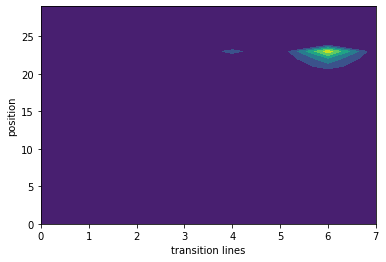

In [4]:
plt.contourf(data[0,:,:]) # Third angle:
plt.xlabel('transition lines')
plt.ylabel('position')
plt.show()

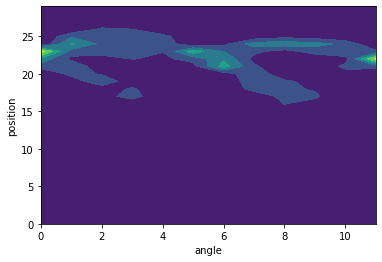

In [5]:
plt.contourf(data[:,:,6].transpose()) # Third angle:
plt.xlabel('angle')
plt.ylabel('position')
plt.show()

# Test how reshape works:

In [15]:
n_batch=6

a=np.arange(1,241)
print(a.shape)

b=a.reshape(30, 8)
#print(b)
#print(b.shape)

c=b.reshape(n_batch, b.shape[0]//n_batch, -1)
print(c[0])

(240,)
[[ 1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16]
 [17 18 19 20 21 22 23 24]
 [25 26 27 28 29 30 31 32]
 [33 34 35 36 37 38 39 40]]


# Make mini-batch:

In [7]:
n_batch=6

# Take first angle:
angle = data[0]
print(angle.shape)

# Reshape
second_dim = angle.shape[0]//n_batch
y = angle.reshape(n_batch, second_dim, -1)
y.shape

(30, 8)


(6, 5, 8)

# Create the map of probe attenuation ratio

In [17]:
# xraylib uses keV
fl_K = np.array([xlib.KA1_LINE, xlib.KA2_LINE, xlib.KA3_LINE, xlib.KB1_LINE, xlib.KB2_LINE,
                 xlib.KB3_LINE, xlib.KB4_LINE, xlib.KB5_LINE])

fl_L = np.array([xlib.LA1_LINE, xlib.LA2_LINE, xlib.LB1_LINE, xlib.LB2_LINE, xlib.LB3_LINE,
                 xlib.LB4_LINE, xlib.LB5_LINE, xlib.LB6_LINE, xlib.LB7_LINE, xlib.LB9_LINE,
                 xlib.LB10_LINE, xlib.LB15_LINE, xlib.LB17_LINE])

fl_M = np.array([xlib.MA1_LINE, xlib.MA2_LINE, xlib.MB_LINE])

In [9]:
def attenuation_theta(src_path, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n,
                sample_size_cm, this_aN_dic, probe_energy, padding=True):
    """
    Calculate the attenuation ratio of the incident beam before the beam travels to a certain voxel.
    Assuming that the x-ray probe goes along the direction of axis=1 of the sample array.
    Calculate the transmission ratio at the exit of the sample.
    
    Parameters
    ----------
    src_path: string
        the path of the elemental map
        
    theta_st: float
        The initial angle of the sample, in degree
        
    theta_end: float
        The final angle of the sample, in degree
    
    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels
    
    sample_size_cm: scalar
        sample size in cm
    
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}
        
    Returns: 2 ndarrays
    -------
        The 1st array is the attenuation ratio of the incident beam before the beam 
        travels to a certain voxel. Assuming that the x-ray probe goes along the direction
        of axis=1 of the sample array.
        dimension of the 1st returned array is (n_theta, sample_size_n, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
              
        The 2nd array is the transmission ratio of the incident beam at the exit of 
        the sample.
        dimension of the 2st returned array is (n_theta, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
    """
    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))
    
    probe_attCS_ls = xlib_np.CS_Total(aN_ls, probe_energy).flatten()
    probe_attCS_dic = dict(zip(element_ls, probe_attCS_ls))
    
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    theta = theta_ls[this_theta_idx]
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width
        att_exponent_acc_map = np.zeros((sample_size_n, sample_size_n + 1))
        for j, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map = np.pad(concentration_map, (padding_width, padding_width), mode="constant", constant_values=(0,0))
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            lac_single = concentration_map_rot * probe_attCS_dic[element]
            lac_acc = np.cumsum(lac_single, axis=1)
            lac_acc = np.insert(lac_acc, 0, np.zeros(concentration_map.shape[0]), axis=1)
            att_exponent_acc = lac_acc * (sample_size_cm / (sample_size_n - 2 * padding_width))
            att_exponent_acc_map += att_exponent_acc 
    else:
        att_exponent_acc_map = np.zeros((sample_size_n, sample_size_n+1))
        for j, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            lac_single = concentration_map_rot * probe_attCS_dic[element]
            lac_acc = np.cumsum(lac_single, axis=1)
            lac_acc = np.insert(lac_acc, 0, np.zeros(concentration_map.shape[0]), axis=1)
            att_exponent_acc = lac_acc * (sample_size_cm / sample_size_n)
            att_exponent_acc_map += att_exponent_acc   
                
    attenuation_map_theta_flat = np.exp(-(att_exponent_acc_map[:,:-1].reshape(sample_size_n * sample_size_n)))
    transmission_theta = np.exp(-att_exponent_acc_map[:,-1])
    return attenuation_map_theta_flat, transmission_theta

In [10]:
def create_probe_after_attenuation_theta_flat(src_path, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, probe_cts, padding=True):      
    """

    Parameters
    ----------
    src_path : TYPE
        DESCRIPTION.
    theta_st : TYPE
        DESCRIPTION.
    theta_end : TYPE
        DESCRIPTION.
    n_theta : TYPE
        DESCRIPTION.
    sample_size_n : TYPE
        DESCRIPTION.
    sample_size_cm : TYPE
        DESCRIPTION.
    this_aN_dic : TYPE
        DESCRIPTION.
    probe_energy : TYPE
        DESCRIPTION.
    probe_cts : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    probe_after_attenuation_flat : ndarray
        photon counts that enter each voxel at some theta after attenuation. dimension: (sample_size_n * sample_size_n)

    """
    probe_before_attenuation_flat = create_probe_before_attnuation_flat(sample_size_n, probe_cts, padding)
    att_ratio_map_theta_flat = attenuation_theta(src_path, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, 
                                                 sample_size_cm, this_aN_dic, probe_energy, padding)[0]
    probe_after_attenuation_theta_flat = probe_before_attenuation_flat * att_ratio_map_theta_flat
    return probe_after_attenuation_theta_flat

In [11]:
def generate_fl_signal_from_each_voxel_theta(src_path, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding=True):
    """
    Parameters
    ----------
    src_path : TYPE
        DESCRIPTION.
    theta_st : TYPE
        DESCRIPTION.
    theta_end : TYPE
        DESCRIPTION.
    n_theta : TYPE
        DESCRIPTION.
    sample_size_n : TYPE
        DESCRIPTION.
    sample_size_cm : TYPE
        DESCRIPTION.
    this_aN_dic : TYPE
        DESCRIPTION.
    probe_energy : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    fl_map_tot : ndarray
        fl_map_tot shows the ratio of the probe that is converted into fl signal for each elemental line 
        at each theta at each translational position.
        The dimension of fl_map_tot is (sample_size_n * sample_size_n, n_elemental_line)

    """
    element_ls = np.array(list(this_aN_dic.keys()))
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    theta = theta_ls[this_theta_idx]
    fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True)
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width      
        fl_map_tot_theta = np.zeros((sample_size_n * sample_size_n, len(fl_all_lines_dic["(element_name, Line)"])))
        line_idx = 0
        for j, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map = np.pad(concentration_map, (padding_width, padding_width), mode="constant", constant_values=(0,0))
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            concentration_map_rot_flat = concentration_map_rot.flatten()
            fl_unit = fl_all_lines_dic["detected_fl_unit_concentration"][fl_all_lines_dic["(element_name, Line)"][:,0] == element]
            
            ## FL signal over the current elemental lines for each voxel
            fl_map = np.array([concentration_map_rot_flat * fl_unit_single_line for fl_unit_single_line in fl_unit])
            fl_map = np.transpose(fl_map)
            
            fl_map_tot_theta[:,line_idx:line_idx + fl_map.shape[1]] = fl_map
            line_idx = line_idx + len(fl_unit)
    return fl_map_tot_theta  

In [12]:
def create_XRF_data_single_theta(theta_st, theta_end, n_theta, this_theta_idx, src_path, det_size_n, det_size_cm, det_from_sample_cm,
                                 sample_size_n, sample_size_cm, this_aN_dic, probe_cts, probe_energy, save_path, padding=True):
    
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    theta = theta_ls[this_theta_idx]
    
    probe_after_attenuation_theta = create_probe_after_attenuation_theta_flat(src_path, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, probe_cts)
    fl_ratio_map_tot_theta = generate_fl_signal_from_each_voxel_theta(src_path, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding)    
    fl_signal_wo_SA_theta = probe_after_attenuation_theta[:, np.newaxis] * fl_ratio_map_tot_theta
    
    SA_att_ratio_theta = self_absorption_att_ratio_single_theta(src_path, det_size_n, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, 
                                       this_aN_dic, probe_energy, theta, padding)    
    fl_signal_SA_theta = fl_signal_wo_SA_theta * SA_att_ratio_theta
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width       
        fl_signal_SA_theta = fl_signal_SA_theta.reshape(sample_size_n, sample_size_n, -1)
        fl_signal_SA_theta = np.sum(fl_signal_SA_theta, axis=1)
    
    np.save(os.path.join(save_path, 'XRF_theta_{}_sample1.npy'.format(theta)), fl_signal_SA_theta)
    return fl_signal_SA_theta

# Inherit nn.Module to make our own model:

In [56]:
class PPM(nn.Module):
    def __init__(self, N, M, L):
        """
        Initialize the attributes of PPM.
        """
        super(PPM, self).__init__() # inherit the __init__ from nn.Module.
        
        self.N = N                  # N should be y.shape[1].
        self.M = M                  # M is the number of elements.
        self.L = L                  # L should be y.shape[2].
        self.x = self.init_x()  # initialize self.x with method init_x().
        
    def init_x(self):
        """
        Initialize self.x with 5x30x5 zero tensor.
        """
        return nn.Parameter(torch.zeros(self.N, 30, self.M))
    
    
    def F(self, h):
        """
        Some function which would not change during training. This function is going to convert self.x to 
        the correct dimension as y. Here we use matrix multiplication as an example.
        """
        h_sum = torch.sum(h, dim = 1)    
        M = torch.randn(self.M, self.L)
        return torch.matmul(h_sum, M)
        
    def forward(self):
        """
        Forward propagation.
        """
        output = self.F(self.x)
        return output

In [55]:
h = torch.randn(5, 30, 5)
h_sum = torch.sum(h, dim = 1)
print(M.shape)
M = torch.zeros(5, 8)

print(torch.matmul(h_sum, M).shape)

torch.Size([5, 8])
torch.Size([5, 8])


In [58]:
list(model.parameters())[0]

Parameter containing:
tensor([[[-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234,  0.1355,  0.1578, -0.0368],
         [-0.0043,  0.1234

In [57]:
Nangle=12

model = PPM(5,5,8).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(Nangle):
    for j in range(n_batch):
    
        y_true = torch.from_numpy(y[j]).double()
        y_hat = model()
        y_hat = y_hat.double()
    
        loss = loss_fn(y_true, y_hat)
    
        optimizer.zero_grad() # reset gradient
        loss.backward()      # calculate gradient with respect to loss function.
        optimizer.step()      # update model parameters
        
    # Check whether model.parameters() is model.x
    print('Is model.parameters()= model.x?', list(model.parameters())[0] is model.x, '\n') # or print(list(model.parameters())[0] == model.x)
    print('Print model.x', model.x, '\n')
    print('Loss for angle {}: {}'.format(i, loss.item()) )

Is model.parameters()= model.x? True 

Print model.x Parameter containing:
tensor([[[-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  0.0041,  0.0235,  0.0215],
         [-0.0223, -0.0034,  

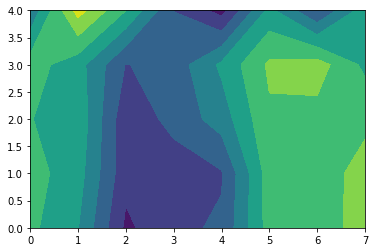

In [229]:
Y=model()
plt.contourf(Y.detach().numpy()) # Remember to detach from the computational graph and convert to numpy in order
                                 # to make plot.
plt.show()